In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


In [2]:
def show_tensor_image(tensor):  # 텐서 순서를 (C, H, W)에서 (H, W, C)로 변경하고 numpy array로 변환
    image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
def val_plot(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Test Loss')

    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')  # , color='orange'
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

In [4]:
def cuda_message():
    if torch.cuda.is_available():
        print("CUDA(GPU)를 사용합니다.")
    else:
        print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda_message()

CUDA(GPU)를 사용합니다.


In [6]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, model_num=18, num_classes=2):
        super(myResNet, self).__init__()

        if model_num == 18:
            self.resnet = models.resnet18(weights=None)
        elif model_num == 34:
            self.resnet = models.resnet34(weights=None)
        elif model_num == 50:
            self.resnet = models.resnet50(weights=None)
        elif model_num == 101:
            self.resnet = models.resnet101(weights=None)
        elif model_num == 152:
            self.resnet = models.resnet152(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
# myVGG 클래스 정의
class myVGG(nn.Module):
    def __init__(self, model_kind="16", num_classes=2):
        super(myVGG, self).__init__()

        if model_kind == "11":
            self.vgg = models.vgg11(weights=None)
        elif model_kind == "11_bn":
            self.vgg = models.vgg11_bn(weights=None)
        elif model_kind == "13":
            self.vgg = models.vgg13(weights=None)
        elif model_kind == "13_bn":
            self.vgg = models.vgg13_bn(weights=None)
        elif model_kind == "16":
            self.vgg = models.vgg16(weights=None)
        elif model_kind == "16_bn":
            self.vgg = models.vgg16_bn(weights=None)
        elif model_kind == "19":
            self.vgg = models.vgg19(weights=None)
        elif model_kind == "19_bn":
            self.vgg = models.vgg19_bn(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vgg.classifier[6].in_features  # classifier["6"] -> 6, vgg에서 정해진 수?
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [8]:
# myLeNet 클래스 정의
class myLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(myLeNet, self).__init__()
        self.lenet = models.googlenet(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.lenet.fc.in_features
        self.lenet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.lenet(x)

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()  # 어차피 train에선 test와 달리 loss.backward() 해야하기 때문에 loss 따로 객체화
        loss.backward()
        optimizer.step()
    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)  # output.argmax(dim=1, keepdim=True)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()  # pred.eq(target.view_as(pred)).sum().item()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # .view_as(): View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size())
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()
    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [12]:
# import shutil
# shutil.rmtree('C:/Users/bgmbg/Downloads/face_age/.ipynb_checkpoints')

In [13]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

# 아래 수정/출력 요망

# full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
# test_dataset_origin = ImageFolder('IMAGE/Covid19-dataset/test', transform=trans_origin)
# test_loader_origin = torch.utils.data.DataLoader(test_dataset_origin, batch_size=64, shuffle=False)

# original_images, _ = next(iter(test_loader_origin))
# transform_images, _ = next(iter(test_loader))

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(4, 6)

# for idx in range(3):
#     axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 0].set_axis_off()
#     axes[idx, 0].set_title('Original (200,200)')
#     axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 1].set_axis_off()
#     axes[idx, 1].set_title('Resized (100,100)')
#     axes[idx, 2].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 2].set_axis_off()
#     axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
# plt.show()

In [14]:
torch.manual_seed(42)

# 데이터 전처리
transform = transforms.Compose([
    # transforms.Resize((50, 50)),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874),
                         (0.21104145, 0.18984404, 0.18253866))  # 이미지를 -1에서 1로 정규화
])
# 데이터셋 로드
full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
print(full_dataset)
count = Counter(full_dataset.targets)
print(count)

# 데이터를 훈련셋과 테스트셋으로 랜덤으로 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

cnt = []
for i in range(train_size):  #
    cnt.append(train_dataset[i][1])
print(Counter(cnt))
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 9778
    Root location: ./face_age
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.6360717, 0.4874842, 0.41885874), std=(0.21104145, 0.18984404, 0.18253866))
           )
Counter({0: 1112, 6: 856, 17: 794, 4: 759, 5: 661, 3: 554, 8: 554, 9: 554, 12: 539, 16: 521, 7: 480, 13: 399, 11: 371, 2: 355, 14: 339, 15: 317, 1: 309, 10: 304})
Counter({0: 898, 6: 687, 17: 630, 4: 612, 5: 536, 3: 449, 8: 438, 9: 433, 12: 428, 16: 423, 7: 388, 13: 312, 11: 296, 2: 286, 14: 275, 15: 247, 1: 242, 10: 242})


In [15]:
# 인덱스, 눈금 수정 요망
# age_sorted = ['1', '2-3', '4-6', '7-9', '10-12',
#               '13-15', '16-19', '20-24', '25-29', '30-34',
#               '35-39', '40-44', '45-49', '50-54', '55-59',
#               '60-64', '65-69', '70']
# age_dict = {'1': 0, '10-12': 1, '13-15': 2, '16-19': 3, '2-3': 4,
#             '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, '4-6': 9,
#             '40-44': 10, '45-49': 11, '50-54': 12, '55-59': 13, '60-64': 14,
#             '65-69': 15, '7-9': 16, '70': 17}

# age_list = list(count.keys())
# frequencies = list(count.values())

# plt.bar(age_list, frequencies)
# plt.xlabel('age')
# plt.show()

In [16]:
### 1. resnet18
### 1-1. resnet18 / SGD
### 1-2. resnet18 / RMSprop
### 1-3. resnet18 / AdamW
### 2. vgg13
### 3. googlenet

### 1-1-1. resnet18 / SGD(lr=0.010, mo=0.9)

In [19]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [20]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [21]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4552, Accuracy: 50.00%
Test loss: 2.1037, Accuracy: 26.23%
Epoch 2, Training loss: 1.9808, Accuracy: 14.29%
Test loss: 2.1799, Accuracy: 28.17%
Epoch 3, Training loss: 1.7630, Accuracy: 21.43%
Test loss: 1.8243, Accuracy: 36.04%
Epoch 4, Training loss: 1.5019, Accuracy: 35.71%
Test loss: 2.1613, Accuracy: 27.91%
Epoch 5, Training loss: 1.2945, Accuracy: 35.71%
Test loss: 2.1449, Accuracy: 33.23%
Epoch 6, Training loss: 1.0598, Accuracy: 50.00%
Test loss: 2.3174, Accuracy: 31.49%
Epoch 7, Training loss: 0.8728, Accuracy: 64.29%
Test loss: 2.5586, Accuracy: 30.78%
Epoch 8, Training loss: 0.6390, Accuracy: 78.57%
Test loss: 2.6383, Accuracy: 34.56%
Epoch 9, Training loss: 0.4592, Accuracy: 64.29%
Test loss: 2.8405, Accuracy: 33.13%
Epoch 10, Training loss: 0.3446, Accuracy: 78.57%
Test loss: 3.0906, Accuracy: 34.56%
Epoch 11, Training loss: 0.2938, Accuracy: 100.00%
Test loss: 3.0990, Accuracy: 35.02%
Epoch 12, Training loss: 0.1774, Accuracy: 100.00%
Test loss: 

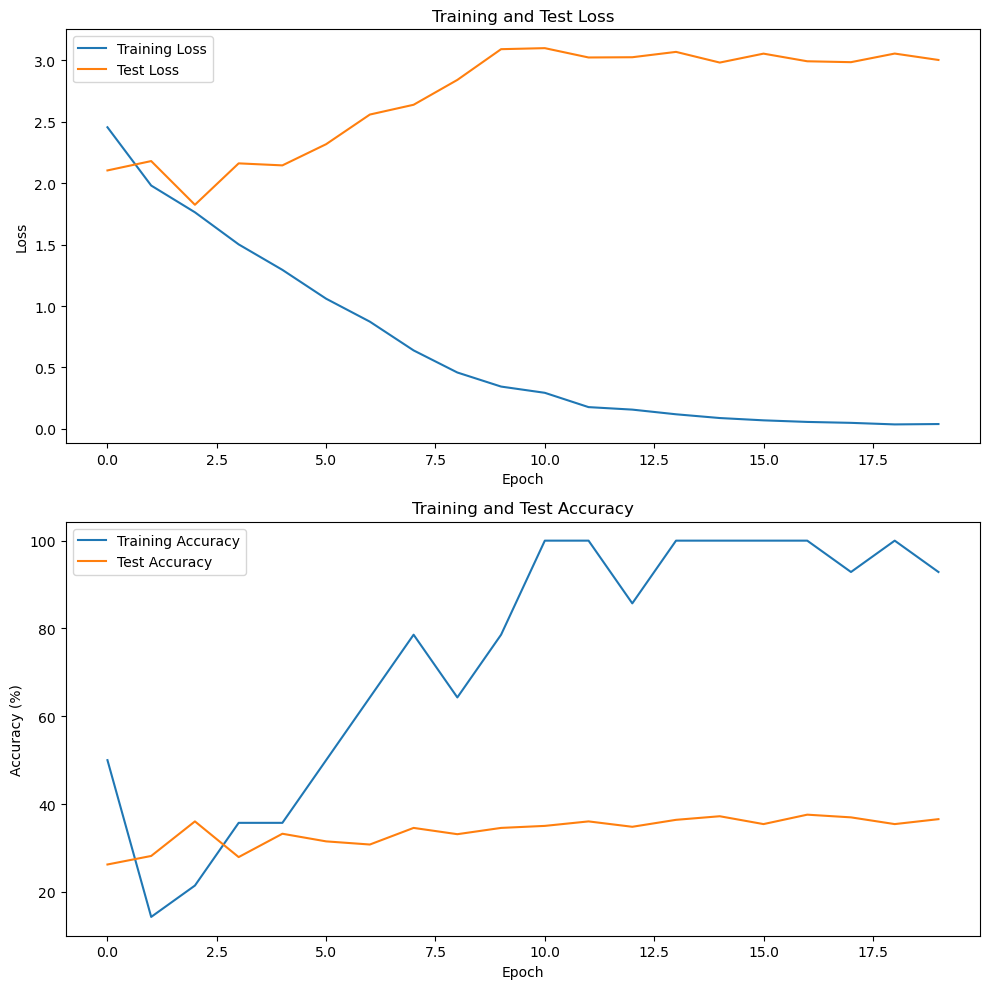

In [22]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-2. resnet18 / SGD(lr=0.010, mo=0.5)

In [23]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.5)

In [24]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [25]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6320, Accuracy: 21.43%
Test loss: 2.4258, Accuracy: 18.05%
Epoch 2, Training loss: 2.1976, Accuracy: 21.43%
Test loss: 2.2021, Accuracy: 26.99%
Epoch 3, Training loss: 1.9611, Accuracy: 14.29%
Test loss: 2.1446, Accuracy: 22.65%
Epoch 4, Training loss: 1.7774, Accuracy: 28.57%
Test loss: 2.3488, Accuracy: 24.39%
Epoch 5, Training loss: 1.6166, Accuracy: 35.71%
Test loss: 1.8952, Accuracy: 31.65%
Epoch 6, Training loss: 1.4261, Accuracy: 21.43%
Test loss: 1.8958, Accuracy: 32.00%
Epoch 7, Training loss: 1.2369, Accuracy: 50.00%
Test loss: 2.0203, Accuracy: 33.23%
Epoch 8, Training loss: 1.0527, Accuracy: 78.57%
Test loss: 2.0704, Accuracy: 34.05%
Epoch 9, Training loss: 0.8649, Accuracy: 64.29%
Test loss: 2.0180, Accuracy: 34.10%
Epoch 10, Training loss: 0.6823, Accuracy: 85.71%
Test loss: 2.8923, Accuracy: 24.23%
Epoch 11, Training loss: 0.5419, Accuracy: 57.14%
Test loss: 2.4750, Accuracy: 31.85%
Epoch 12, Training loss: 0.4117, Accuracy: 92.86%
Test loss: 2.

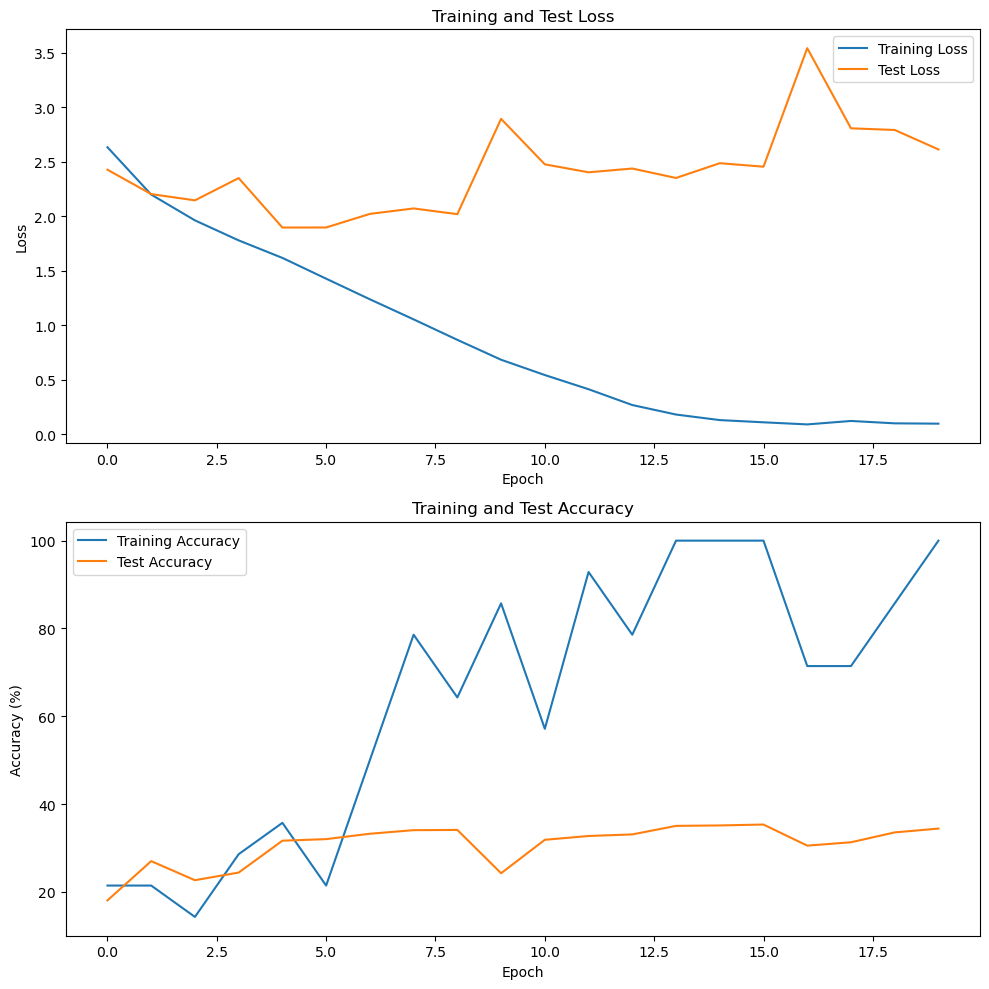

In [26]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-3. resnet18 / SGD(lr=0.010, mo=0.25)

In [27]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.25)

In [28]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [29]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6842, Accuracy: 7.14%
Test loss: 2.5805, Accuracy: 18.46%
Epoch 2, Training loss: 2.3373, Accuracy: 35.71%
Test loss: 2.3197, Accuracy: 23.88%
Epoch 3, Training loss: 2.1204, Accuracy: 28.57%
Test loss: 2.1127, Accuracy: 27.35%
Epoch 4, Training loss: 1.9434, Accuracy: 7.14%
Test loss: 2.2425, Accuracy: 22.29%
Epoch 5, Training loss: 1.7949, Accuracy: 42.86%
Test loss: 2.1499, Accuracy: 25.97%
Epoch 6, Training loss: 1.6526, Accuracy: 28.57%
Test loss: 1.8806, Accuracy: 34.36%
Epoch 7, Training loss: 1.5068, Accuracy: 50.00%
Test loss: 1.8594, Accuracy: 33.23%
Epoch 8, Training loss: 1.3478, Accuracy: 28.57%
Test loss: 2.2962, Accuracy: 30.62%
Epoch 9, Training loss: 1.2038, Accuracy: 85.71%
Test loss: 2.4116, Accuracy: 27.81%
Epoch 10, Training loss: 1.0466, Accuracy: 35.71%
Test loss: 2.2343, Accuracy: 31.24%
Epoch 11, Training loss: 0.8810, Accuracy: 64.29%
Test loss: 2.5115, Accuracy: 28.37%
Epoch 12, Training loss: 0.7469, Accuracy: 78.57%
Test loss: 2.28

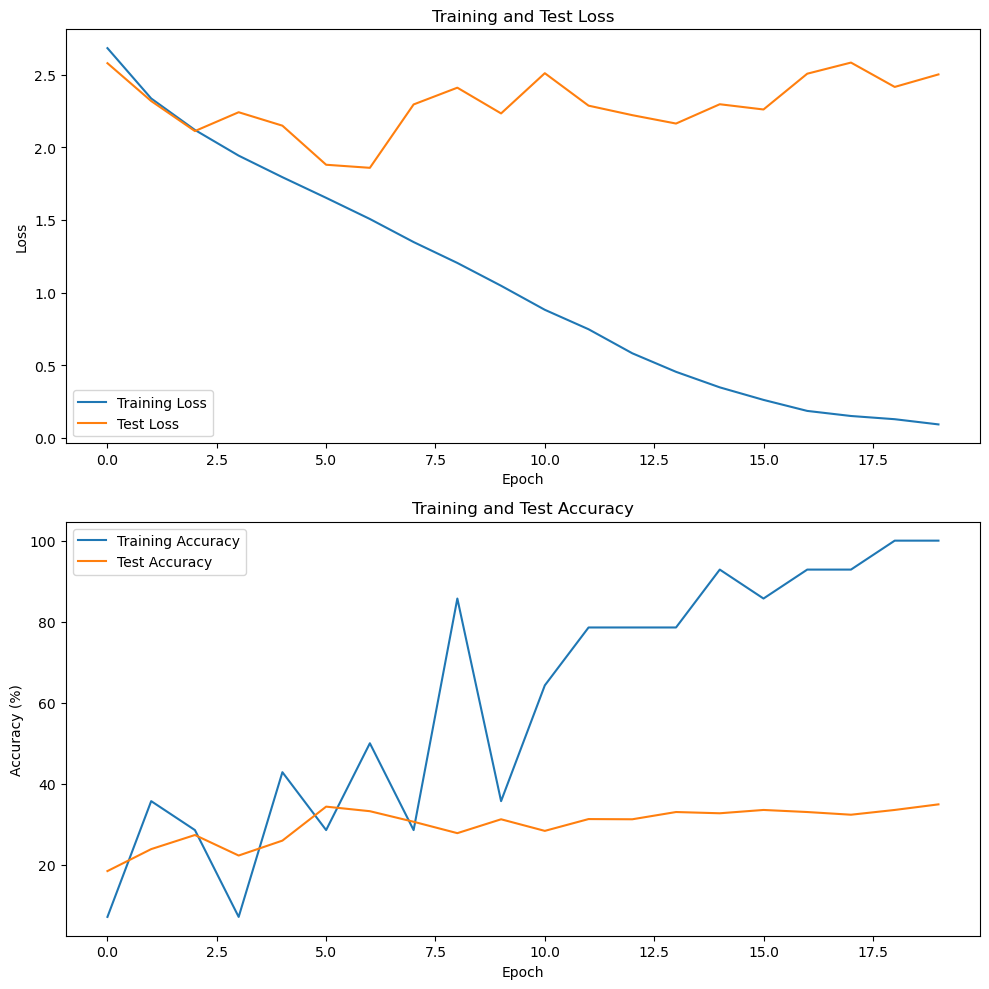

In [30]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-4. resnet18 / SGD(lr=0.005, mo=0.9)

In [31]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [32]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [33]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5440, Accuracy: 28.57%
Test loss: 2.2210, Accuracy: 26.69%
Epoch 2, Training loss: 2.0430, Accuracy: 14.29%
Test loss: 2.0701, Accuracy: 28.94%
Epoch 3, Training loss: 1.7926, Accuracy: 42.86%
Test loss: 1.8599, Accuracy: 34.51%
Epoch 4, Training loss: 1.5991, Accuracy: 21.43%
Test loss: 1.9217, Accuracy: 34.05%
Epoch 5, Training loss: 1.3830, Accuracy: 42.86%
Test loss: 2.0798, Accuracy: 33.33%
Epoch 6, Training loss: 1.1642, Accuracy: 57.14%
Test loss: 1.9319, Accuracy: 36.71%
Epoch 7, Training loss: 0.9292, Accuracy: 50.00%
Test loss: 2.1708, Accuracy: 34.66%
Epoch 8, Training loss: 0.6966, Accuracy: 64.29%
Test loss: 2.6395, Accuracy: 31.70%
Epoch 9, Training loss: 0.4944, Accuracy: 92.86%
Test loss: 2.6177, Accuracy: 33.69%
Epoch 10, Training loss: 0.3151, Accuracy: 85.71%
Test loss: 2.7212, Accuracy: 35.22%
Epoch 11, Training loss: 0.2414, Accuracy: 92.86%
Test loss: 2.7194, Accuracy: 35.84%
Epoch 12, Training loss: 0.1751, Accuracy: 78.57%
Test loss: 2.

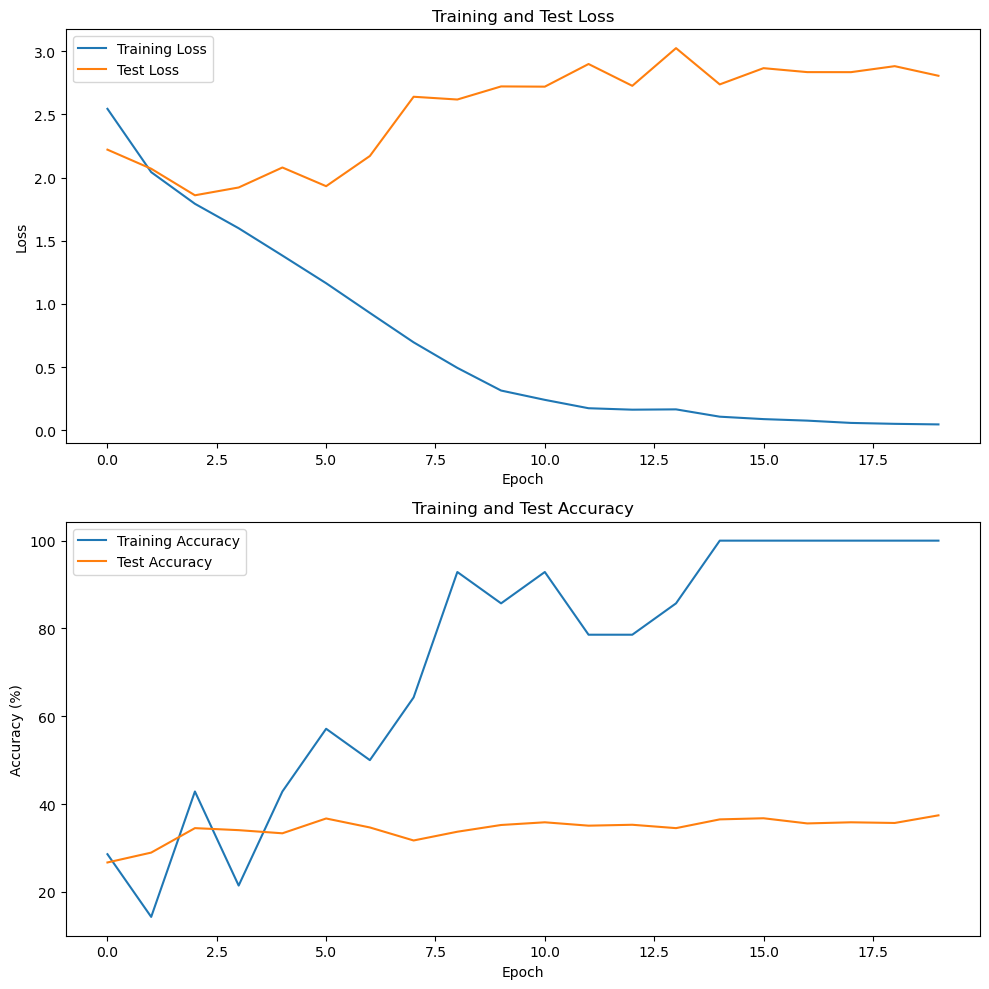

In [34]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-5. resnet18 / SGD(lr=0.005, mo=0.5)

In [35]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

In [36]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [37]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7240, Accuracy: 0.00%
Test loss: 2.6353, Accuracy: 17.18%
Epoch 2, Training loss: 2.4824, Accuracy: 35.71%
Test loss: 2.3553, Accuracy: 24.64%
Epoch 3, Training loss: 2.2091, Accuracy: 35.71%
Test loss: 2.2212, Accuracy: 26.84%
Epoch 4, Training loss: 2.0417, Accuracy: 21.43%
Test loss: 2.0885, Accuracy: 29.70%
Epoch 5, Training loss: 1.9111, Accuracy: 21.43%
Test loss: 2.0140, Accuracy: 31.34%
Epoch 6, Training loss: 1.7742, Accuracy: 64.29%
Test loss: 2.0030, Accuracy: 30.83%
Epoch 7, Training loss: 1.6632, Accuracy: 14.29%
Test loss: 2.1129, Accuracy: 30.73%
Epoch 8, Training loss: 1.5369, Accuracy: 42.86%
Test loss: 1.8919, Accuracy: 34.25%
Epoch 9, Training loss: 1.4098, Accuracy: 42.86%
Test loss: 2.0536, Accuracy: 30.93%
Epoch 10, Training loss: 1.2803, Accuracy: 50.00%
Test loss: 1.9442, Accuracy: 33.33%
Epoch 11, Training loss: 1.1469, Accuracy: 50.00%
Test loss: 2.0733, Accuracy: 31.85%
Epoch 12, Training loss: 1.0074, Accuracy: 71.43%
Test loss: 2.0

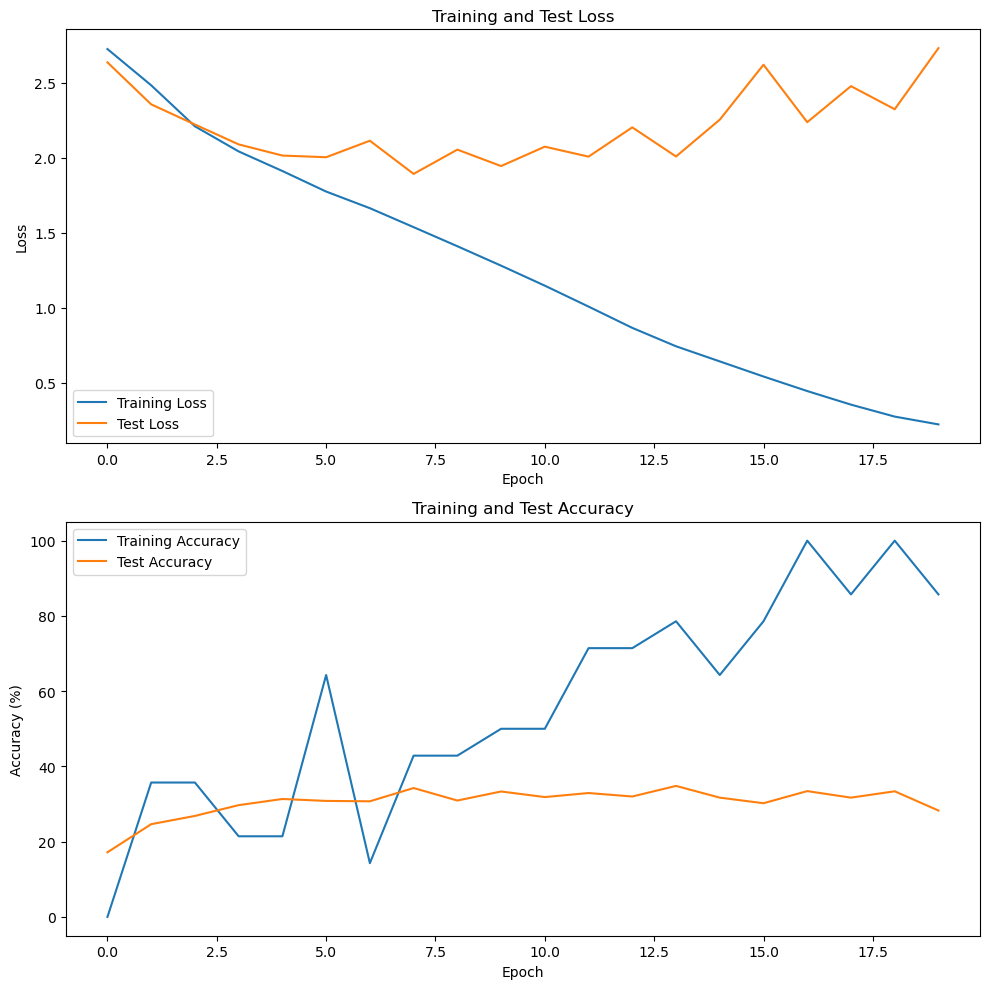

In [38]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-6. resnet18 / SGD(lr=0.005, mo=0.25)

In [39]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.25)

In [40]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [41]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7583, Accuracy: 7.14%
Test loss: 2.6957, Accuracy: 16.31%
Epoch 2, Training loss: 2.5697, Accuracy: 21.43%
Test loss: 2.5178, Accuracy: 19.84%
Epoch 3, Training loss: 2.3685, Accuracy: 14.29%
Test loss: 2.3760, Accuracy: 24.13%
Epoch 4, Training loss: 2.2226, Accuracy: 28.57%
Test loss: 2.2362, Accuracy: 25.66%
Epoch 5, Training loss: 2.1061, Accuracy: 28.57%
Test loss: 2.1736, Accuracy: 25.41%
Epoch 6, Training loss: 2.0058, Accuracy: 42.86%
Test loss: 2.0870, Accuracy: 28.32%
Epoch 7, Training loss: 1.9092, Accuracy: 14.29%
Test loss: 2.2339, Accuracy: 27.66%
Epoch 8, Training loss: 1.8164, Accuracy: 14.29%
Test loss: 2.1058, Accuracy: 27.66%
Epoch 9, Training loss: 1.7229, Accuracy: 35.71%
Test loss: 1.9483, Accuracy: 33.38%
Epoch 10, Training loss: 1.6251, Accuracy: 35.71%
Test loss: 2.0477, Accuracy: 31.60%
Epoch 11, Training loss: 1.5362, Accuracy: 42.86%
Test loss: 1.8692, Accuracy: 35.28%
Epoch 12, Training loss: 1.4423, Accuracy: 50.00%
Test loss: 1.8

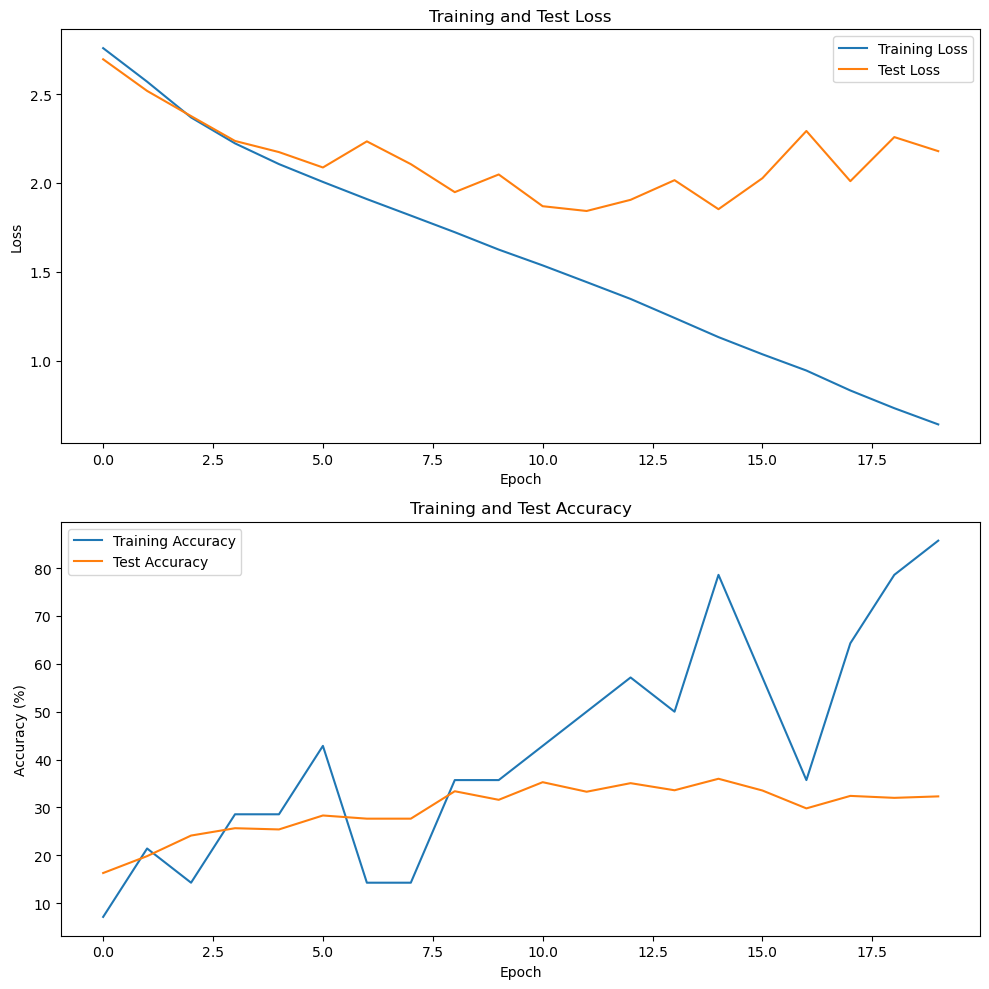

In [42]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-7. resnet18 / SGD(lr=0.001, mo=0.9)

In [17]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [19]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7151, Accuracy: 21.43%
Test loss: 2.6246, Accuracy: 18.35%
Epoch 2, Training loss: 2.4455, Accuracy: 14.29%
Test loss: 2.3591, Accuracy: 23.82%
Epoch 3, Training loss: 2.2098, Accuracy: 35.71%
Test loss: 2.2080, Accuracy: 26.74%
Epoch 4, Training loss: 2.0538, Accuracy: 21.43%
Test loss: 2.0834, Accuracy: 29.45%
Epoch 5, Training loss: 1.9167, Accuracy: 28.57%
Test loss: 2.0687, Accuracy: 29.45%
Epoch 6, Training loss: 1.7950, Accuracy: 35.71%
Test loss: 1.9520, Accuracy: 32.26%
Epoch 7, Training loss: 1.6668, Accuracy: 71.43%
Test loss: 1.8936, Accuracy: 32.46%
Epoch 8, Training loss: 1.5528, Accuracy: 50.00%
Test loss: 1.8598, Accuracy: 33.18%
Epoch 9, Training loss: 1.4221, Accuracy: 28.57%
Test loss: 1.8818, Accuracy: 34.10%
Epoch 10, Training loss: 1.2937, Accuracy: 50.00%
Test loss: 1.7988, Accuracy: 36.04%
Epoch 11, Training loss: 1.1494, Accuracy: 50.00%
Test loss: 1.8038, Accuracy: 35.43%
Epoch 12, Training loss: 1.0075, Accuracy: 28.57%
Test loss: 1.

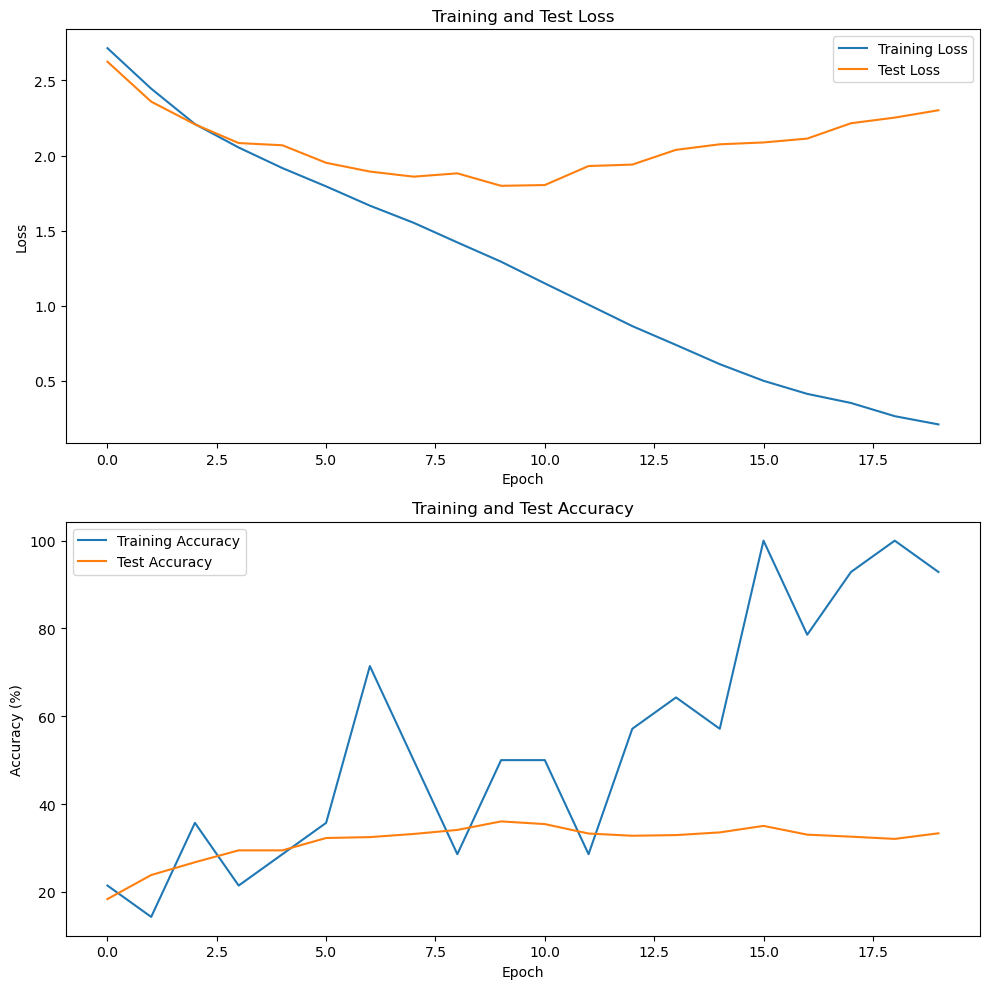

In [20]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-8. resnet18 / SGD(lr=0.001, mo=0.5)

In [21]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8061, Accuracy: 0.00%
Test loss: 2.7718, Accuracy: 15.34%
Epoch 2, Training loss: 2.7276, Accuracy: 21.43%
Test loss: 2.7261, Accuracy: 15.08%
Epoch 3, Training loss: 2.6710, Accuracy: 7.14%
Test loss: 2.6763, Accuracy: 16.92%
Epoch 4, Training loss: 2.6203, Accuracy: 14.29%
Test loss: 2.6371, Accuracy: 17.84%
Epoch 5, Training loss: 2.5648, Accuracy: 21.43%
Test loss: 2.5879, Accuracy: 18.56%
Epoch 6, Training loss: 2.5095, Accuracy: 14.29%
Test loss: 2.5296, Accuracy: 21.22%
Epoch 7, Training loss: 2.4406, Accuracy: 21.43%
Test loss: 2.4668, Accuracy: 22.70%
Epoch 8, Training loss: 2.3702, Accuracy: 14.29%
Test loss: 2.4087, Accuracy: 22.55%
Epoch 9, Training loss: 2.3009, Accuracy: 28.57%
Test loss: 2.3811, Accuracy: 22.75%
Epoch 10, Training loss: 2.2454, Accuracy: 35.71%
Test loss: 2.3459, Accuracy: 24.95%
Epoch 11, Training loss: 2.2001, Accuracy: 42.86%
Test loss: 2.2759, Accuracy: 25.51%
Epoch 12, Training loss: 2.1561, Accuracy: 35.71%
Test loss: 2.22

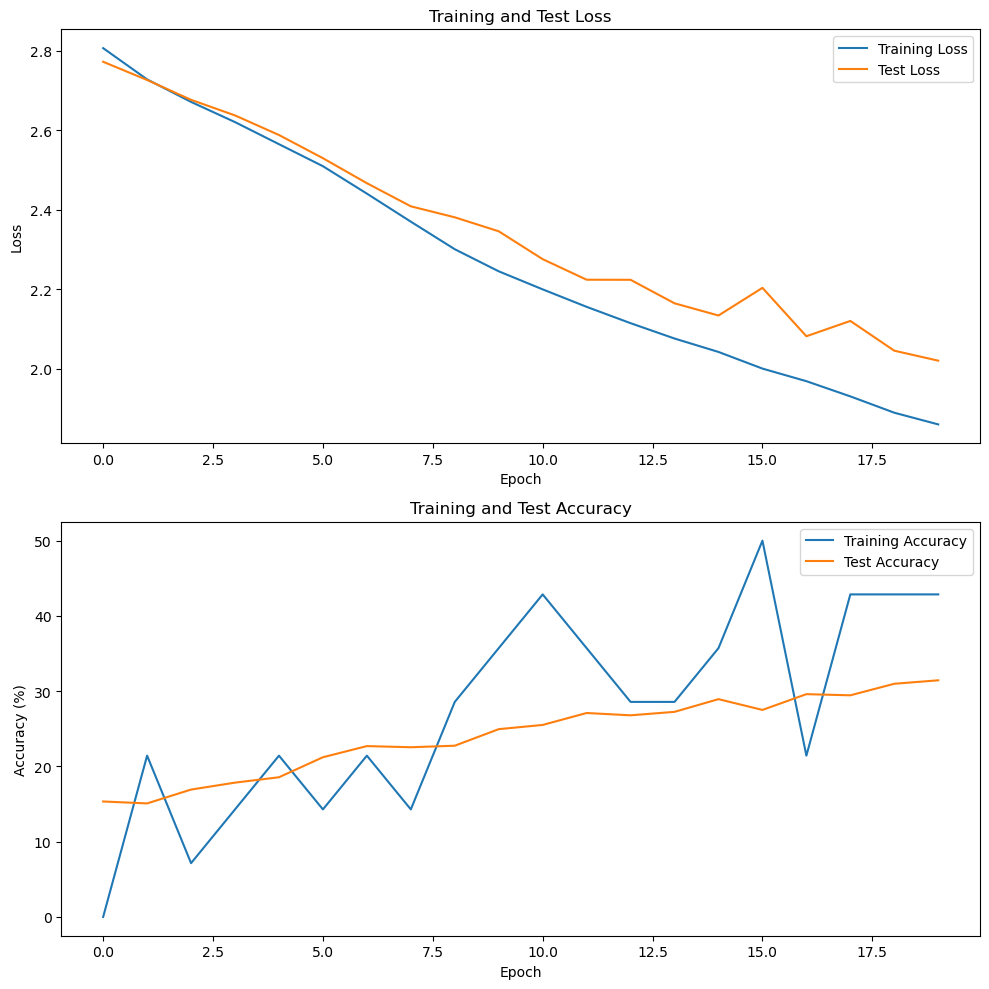

In [24]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-9. resnet18 / SGD(lr=0.001, mo=0.25)

In [25]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.25)

In [26]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [27]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8361, Accuracy: 7.14%
Test loss: 2.7931, Accuracy: 13.60%
Epoch 2, Training loss: 2.7592, Accuracy: 14.29%
Test loss: 2.7615, Accuracy: 14.83%
Epoch 3, Training loss: 2.7208, Accuracy: 21.43%
Test loss: 2.7247, Accuracy: 16.67%
Epoch 4, Training loss: 2.6781, Accuracy: 7.14%
Test loss: 2.6871, Accuracy: 17.28%
Epoch 5, Training loss: 2.6407, Accuracy: 14.29%
Test loss: 2.6586, Accuracy: 17.64%
Epoch 6, Training loss: 2.5992, Accuracy: 14.29%
Test loss: 2.6284, Accuracy: 18.20%
Epoch 7, Training loss: 2.5651, Accuracy: 14.29%
Test loss: 2.6013, Accuracy: 19.12%
Epoch 8, Training loss: 2.5250, Accuracy: 14.29%
Test loss: 2.5689, Accuracy: 19.84%
Epoch 9, Training loss: 2.4880, Accuracy: 35.71%
Test loss: 2.5354, Accuracy: 20.50%
Epoch 10, Training loss: 2.4487, Accuracy: 7.14%
Test loss: 2.4990, Accuracy: 21.27%
Epoch 11, Training loss: 2.4029, Accuracy: 35.71%
Test loss: 2.4646, Accuracy: 22.60%
Epoch 12, Training loss: 2.3650, Accuracy: 0.00%
Test loss: 2.4285

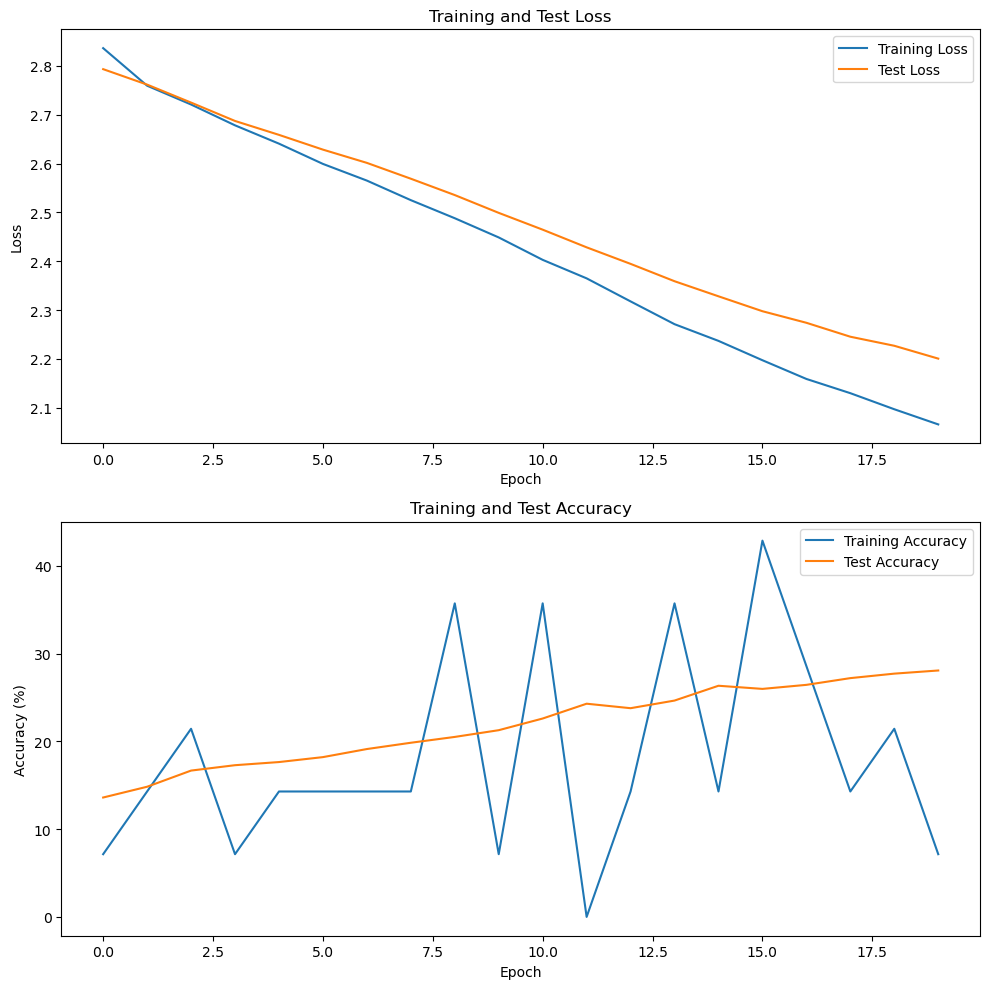

In [28]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-1. resnet18 / RMSprop(lr=0.010, mo=0.9)

In [17]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.9)

In [18]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [19]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.9826, Accuracy: 28.57%
Test loss: 2.6797, Accuracy: 17.48%
Epoch 2, Training loss: 2.6291, Accuracy: 7.14%
Test loss: 2.5370, Accuracy: 20.50%
Epoch 3, Training loss: 2.3986, Accuracy: 35.71%
Test loss: 2.2963, Accuracy: 23.31%
Epoch 4, Training loss: 2.1580, Accuracy: 14.29%
Test loss: 2.1417, Accuracy: 26.23%
Epoch 5, Training loss: 2.0254, Accuracy: 21.43%
Test loss: 2.0611, Accuracy: 27.86%
Epoch 6, Training loss: 1.9064, Accuracy: 21.43%
Test loss: 2.2097, Accuracy: 27.66%
Epoch 7, Training loss: 1.8449, Accuracy: 50.00%
Test loss: 2.0213, Accuracy: 26.02%
Epoch 8, Training loss: 1.7866, Accuracy: 50.00%
Test loss: 2.1655, Accuracy: 28.63%
Epoch 9, Training loss: 1.7409, Accuracy: 28.57%
Test loss: 2.6584, Accuracy: 24.28%
Epoch 10, Training loss: 1.6773, Accuracy: 50.00%
Test loss: 1.8782, Accuracy: 36.25%
Epoch 11, Training loss: 1.5947, Accuracy: 50.00%
Test loss: 1.9268, Accuracy: 34.00%
Epoch 12, Training loss: 1.5472, Accuracy: 28.57%
Test loss: 2.2

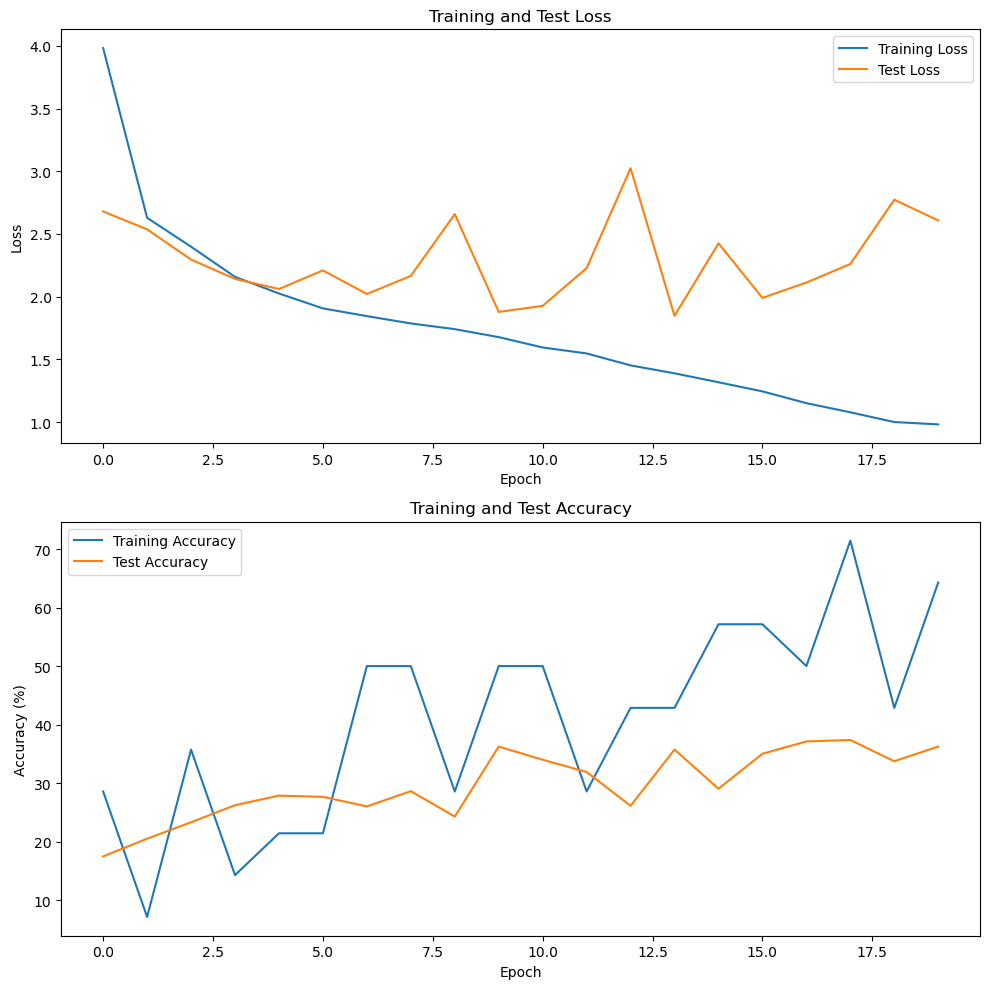

In [20]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-2. resnet18 / RMSprop(lr=0.010, mo=0.5)

In [21]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.5)

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.6927, Accuracy: 0.00%
Test loss: 2.9995, Accuracy: 11.35%
Epoch 2, Training loss: 2.6346, Accuracy: 14.29%
Test loss: 2.4603, Accuracy: 20.04%
Epoch 3, Training loss: 2.2592, Accuracy: 21.43%
Test loss: 2.2632, Accuracy: 21.68%
Epoch 4, Training loss: 2.0897, Accuracy: 21.43%
Test loss: 2.4211, Accuracy: 22.29%
Epoch 5, Training loss: 1.9875, Accuracy: 28.57%
Test loss: 4.0169, Accuracy: 20.45%
Epoch 6, Training loss: 1.8734, Accuracy: 28.57%
Test loss: 2.2136, Accuracy: 27.40%
Epoch 7, Training loss: 1.7900, Accuracy: 28.57%
Test loss: 2.7607, Accuracy: 22.49%
Epoch 8, Training loss: 1.7067, Accuracy: 50.00%
Test loss: 2.1428, Accuracy: 28.94%
Epoch 9, Training loss: 1.6298, Accuracy: 21.43%
Test loss: 1.9860, Accuracy: 31.85%
Epoch 10, Training loss: 1.5565, Accuracy: 28.57%
Test loss: 2.2272, Accuracy: 30.27%
Epoch 11, Training loss: 1.4875, Accuracy: 28.57%
Test loss: 2.0369, Accuracy: 30.57%
Epoch 12, Training loss: 1.3957, Accuracy: 28.57%
Test loss: 2.1

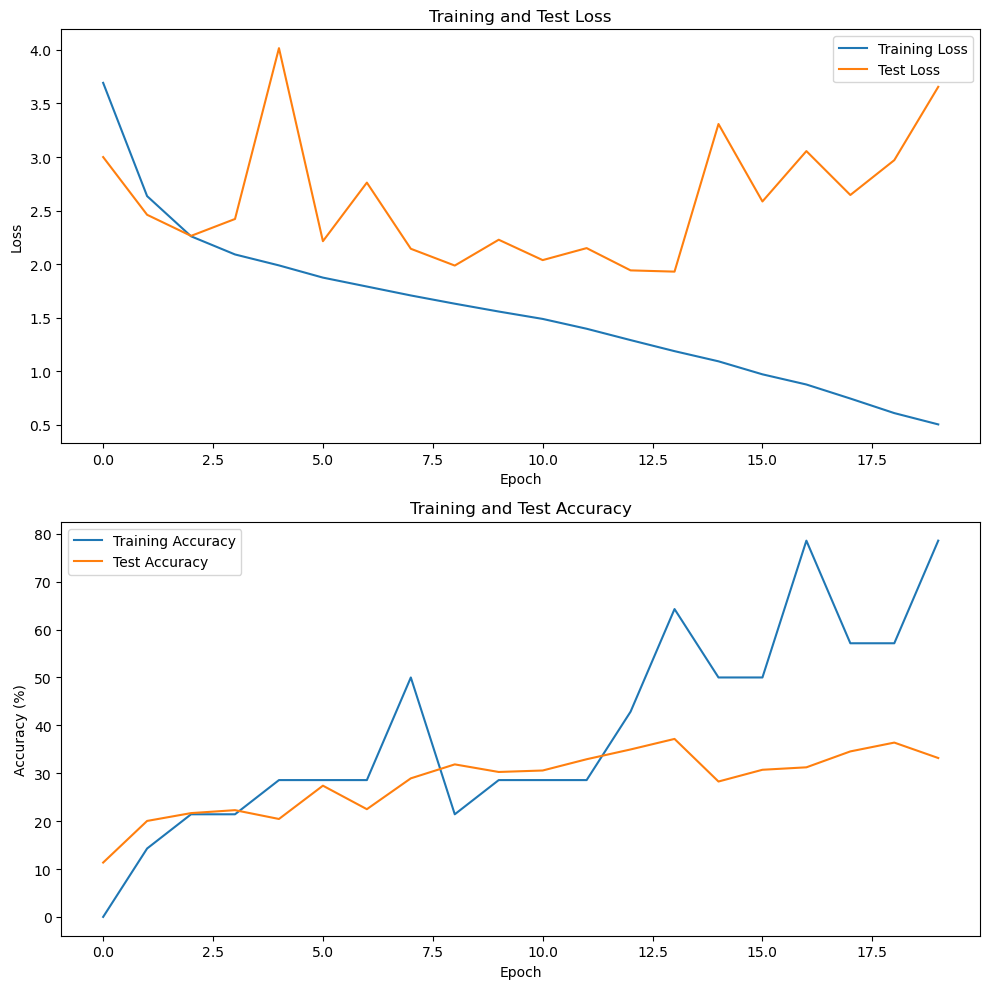

In [24]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-3. resnet18 / RMSprop(lr=0.010, mo=0.25)

In [25]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.25)

In [26]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [27]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.3723, Accuracy: 7.14%
Test loss: 2.9541, Accuracy: 13.04%
Epoch 2, Training loss: 2.5024, Accuracy: 14.29%
Test loss: 2.4964, Accuracy: 21.11%
Epoch 3, Training loss: 2.2473, Accuracy: 21.43%
Test loss: 2.5464, Accuracy: 18.87%
Epoch 4, Training loss: 2.0826, Accuracy: 0.00%
Test loss: 2.5863, Accuracy: 21.22%
Epoch 5, Training loss: 1.9442, Accuracy: 35.71%
Test loss: 2.2100, Accuracy: 23.62%
Epoch 6, Training loss: 1.8206, Accuracy: 28.57%
Test loss: 2.5298, Accuracy: 24.13%
Epoch 7, Training loss: 1.7263, Accuracy: 35.71%
Test loss: 1.8591, Accuracy: 30.21%
Epoch 8, Training loss: 1.6235, Accuracy: 14.29%
Test loss: 2.5377, Accuracy: 26.74%
Epoch 9, Training loss: 1.5280, Accuracy: 64.29%
Test loss: 2.3521, Accuracy: 30.16%
Epoch 10, Training loss: 1.4402, Accuracy: 42.86%
Test loss: 2.1061, Accuracy: 31.90%
Epoch 11, Training loss: 1.3208, Accuracy: 57.14%
Test loss: 2.5266, Accuracy: 29.91%
Epoch 12, Training loss: 1.1895, Accuracy: 78.57%
Test loss: 1.98

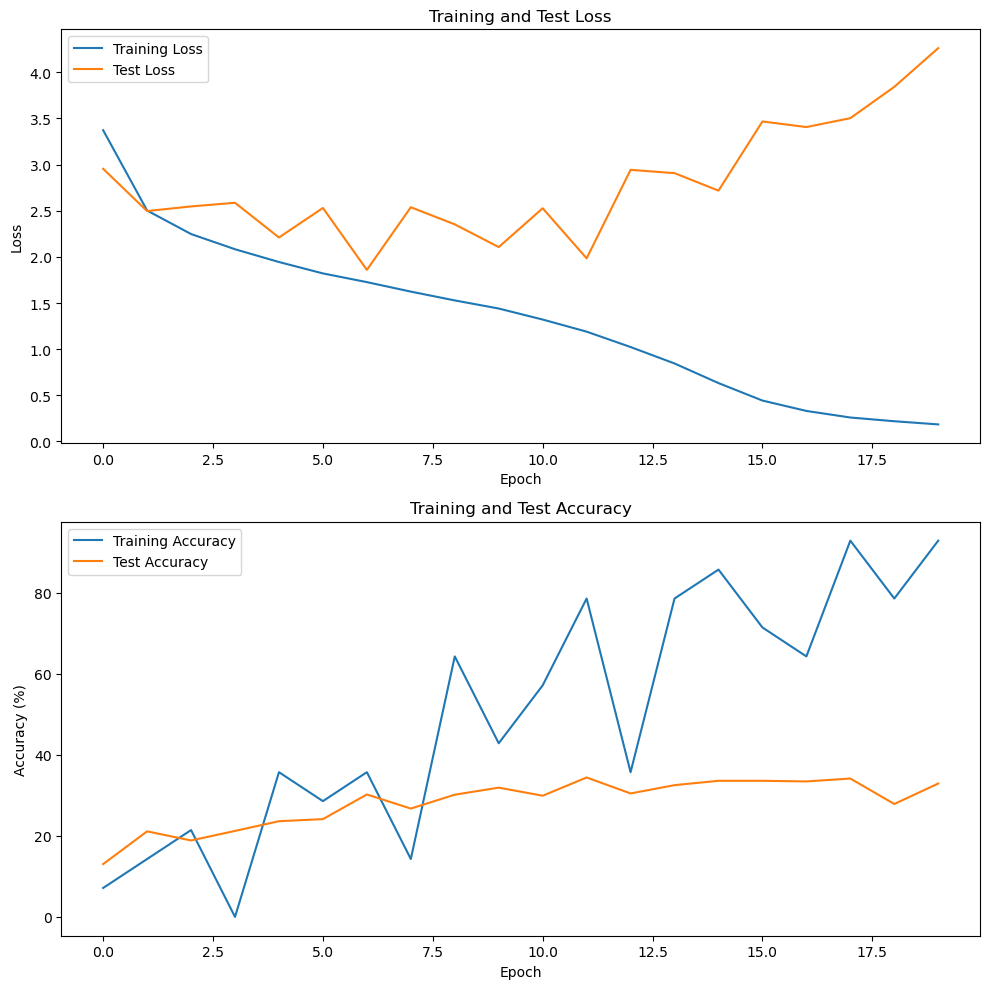

In [28]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-4. resnet18 / RMSprop(lr=0.005, mo=0.9)

In [29]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9)

In [30]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [31]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.5534, Accuracy: 7.14%
Test loss: 2.7729, Accuracy: 14.06%
Epoch 2, Training loss: 2.7070, Accuracy: 14.29%
Test loss: 2.6226, Accuracy: 17.64%
Epoch 3, Training loss: 2.4192, Accuracy: 21.43%
Test loss: 2.2825, Accuracy: 25.00%
Epoch 4, Training loss: 2.2050, Accuracy: 14.29%
Test loss: 2.2649, Accuracy: 25.15%
Epoch 5, Training loss: 2.0687, Accuracy: 35.71%
Test loss: 2.6069, Accuracy: 25.05%
Epoch 6, Training loss: 1.9719, Accuracy: 28.57%
Test loss: 2.0222, Accuracy: 29.29%
Epoch 7, Training loss: 1.8688, Accuracy: 42.86%
Test loss: 2.2575, Accuracy: 28.43%
Epoch 8, Training loss: 1.8260, Accuracy: 28.57%
Test loss: 1.8792, Accuracy: 33.84%
Epoch 9, Training loss: 1.7468, Accuracy: 35.71%
Test loss: 1.9347, Accuracy: 29.50%
Epoch 10, Training loss: 1.6844, Accuracy: 21.43%
Test loss: 2.8496, Accuracy: 24.23%
Epoch 11, Training loss: 1.6289, Accuracy: 7.14%
Test loss: 2.3582, Accuracy: 28.89%
Epoch 12, Training loss: 1.5571, Accuracy: 42.86%
Test loss: 2.05

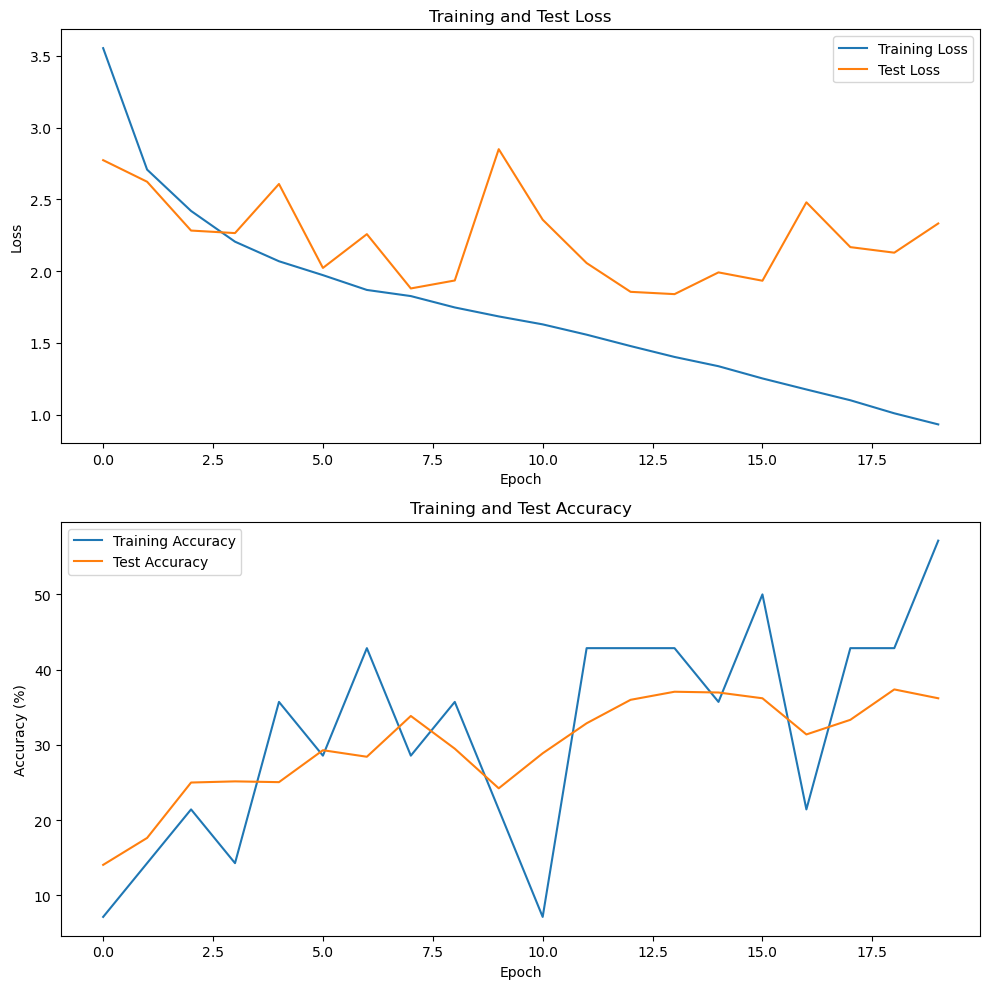

In [32]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-5. resnet18 / RMSprop(lr=0.005, mo=0.5)

In [33]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.5)

In [34]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [35]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.2563, Accuracy: 14.29%
Test loss: 2.7007, Accuracy: 16.26%
Epoch 2, Training loss: 2.4735, Accuracy: 50.00%
Test loss: 2.4193, Accuracy: 22.55%
Epoch 3, Training loss: 2.2189, Accuracy: 42.86%
Test loss: 2.2320, Accuracy: 25.31%
Epoch 4, Training loss: 2.0575, Accuracy: 35.71%
Test loss: 2.1707, Accuracy: 25.15%
Epoch 5, Training loss: 1.9342, Accuracy: 21.43%
Test loss: 2.4832, Accuracy: 24.74%
Epoch 6, Training loss: 1.7970, Accuracy: 50.00%
Test loss: 3.3720, Accuracy: 26.64%
Epoch 7, Training loss: 1.7102, Accuracy: 21.43%
Test loss: 2.0781, Accuracy: 29.29%
Epoch 8, Training loss: 1.6163, Accuracy: 64.29%
Test loss: 1.8623, Accuracy: 35.63%
Epoch 9, Training loss: 1.5205, Accuracy: 42.86%
Test loss: 1.8882, Accuracy: 35.94%
Epoch 10, Training loss: 1.4277, Accuracy: 42.86%
Test loss: 1.8895, Accuracy: 36.04%
Epoch 11, Training loss: 1.3226, Accuracy: 21.43%
Test loss: 1.9702, Accuracy: 34.71%
Epoch 12, Training loss: 1.1706, Accuracy: 50.00%
Test loss: 2.

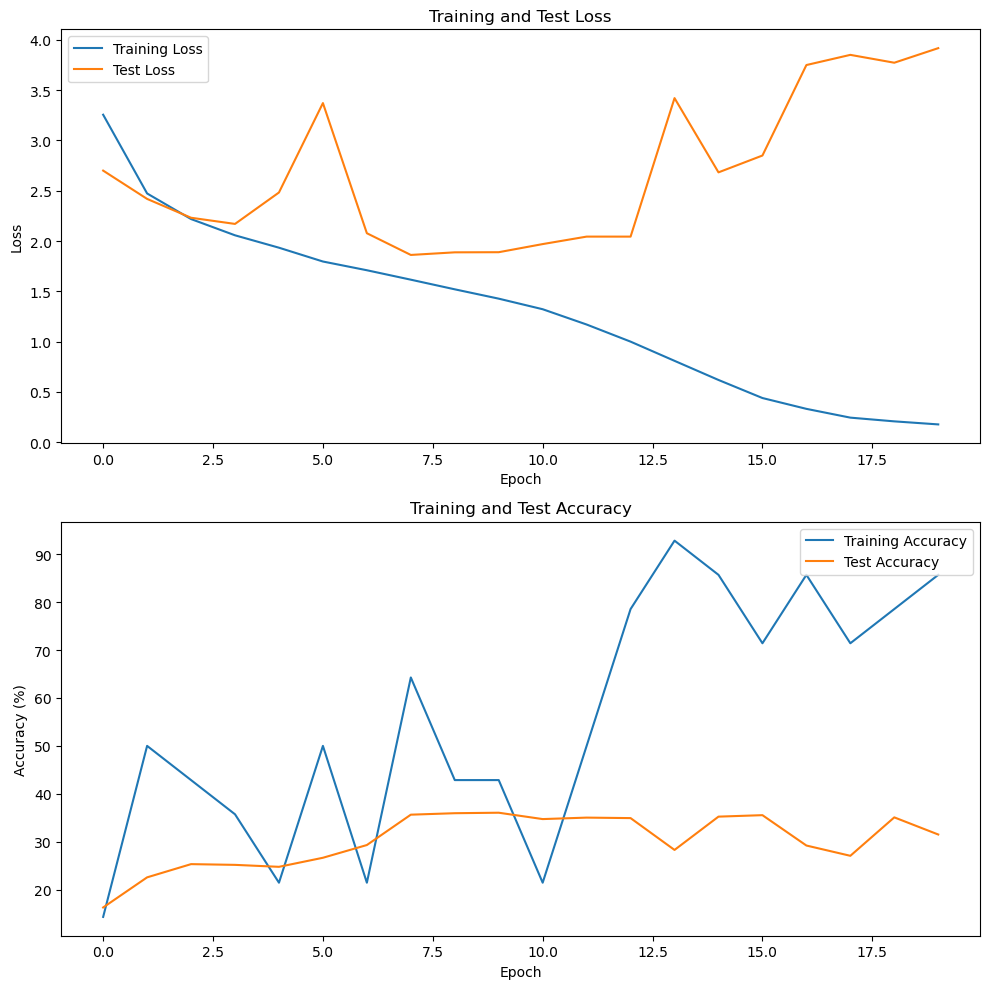

In [36]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-6. resnet18 / RMSprop(lr=0.005, mo=0.25)

In [37]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.25)

In [38]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [39]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.9999, Accuracy: 14.29%
Test loss: 2.7352, Accuracy: 13.04%
Epoch 2, Training loss: 2.2546, Accuracy: 42.86%
Test loss: 2.9986, Accuracy: 18.61%
Epoch 3, Training loss: 2.1073, Accuracy: 0.00%
Test loss: 2.5380, Accuracy: 18.76%
Epoch 4, Training loss: 1.9786, Accuracy: 21.43%
Test loss: 2.3872, Accuracy: 25.46%
Epoch 5, Training loss: 1.8546, Accuracy: 50.00%
Test loss: 2.2647, Accuracy: 23.42%
Epoch 6, Training loss: 1.7685, Accuracy: 35.71%
Test loss: 2.5882, Accuracy: 22.29%
Epoch 7, Training loss: 1.6999, Accuracy: 35.71%
Test loss: 3.3088, Accuracy: 26.74%
Epoch 8, Training loss: 1.5899, Accuracy: 35.71%
Test loss: 2.6714, Accuracy: 23.47%
Epoch 9, Training loss: 1.5001, Accuracy: 50.00%
Test loss: 2.0767, Accuracy: 31.49%
Epoch 10, Training loss: 1.3893, Accuracy: 35.71%
Test loss: 2.0247, Accuracy: 30.93%
Epoch 11, Training loss: 1.2740, Accuracy: 50.00%
Test loss: 2.4155, Accuracy: 26.64%
Epoch 12, Training loss: 1.1277, Accuracy: 57.14%
Test loss: 2.3

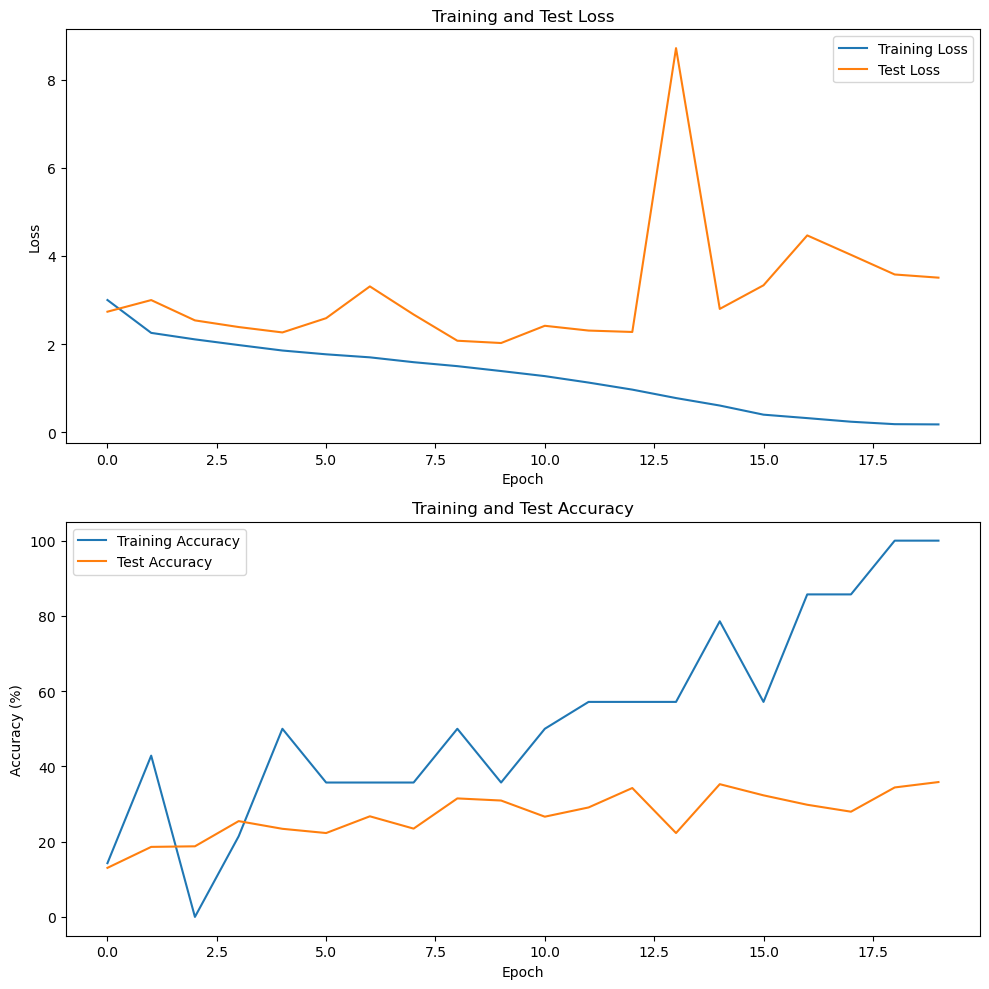

In [40]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-7. resnet18 / RMSprop(lr=0.001, mo=0.9)

In [41]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [42]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [43]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.0692, Accuracy: 42.86%
Test loss: 2.6743, Accuracy: 16.05%
Epoch 2, Training loss: 2.4537, Accuracy: 42.86%
Test loss: 2.2485, Accuracy: 25.26%
Epoch 3, Training loss: 2.1363, Accuracy: 35.71%
Test loss: 2.2474, Accuracy: 25.92%
Epoch 4, Training loss: 1.9801, Accuracy: 35.71%
Test loss: 2.0222, Accuracy: 29.35%
Epoch 5, Training loss: 1.8507, Accuracy: 21.43%
Test loss: 1.9226, Accuracy: 31.29%
Epoch 6, Training loss: 1.7615, Accuracy: 28.57%
Test loss: 1.8957, Accuracy: 33.84%
Epoch 7, Training loss: 1.6698, Accuracy: 50.00%
Test loss: 1.9276, Accuracy: 33.49%
Epoch 8, Training loss: 1.6052, Accuracy: 21.43%
Test loss: 1.7780, Accuracy: 37.47%
Epoch 9, Training loss: 1.5321, Accuracy: 42.86%
Test loss: 1.8090, Accuracy: 34.51%
Epoch 10, Training loss: 1.4579, Accuracy: 35.71%
Test loss: 1.7111, Accuracy: 37.58%
Epoch 11, Training loss: 1.3491, Accuracy: 50.00%
Test loss: 1.8501, Accuracy: 35.33%
Epoch 12, Training loss: 1.2427, Accuracy: 57.14%
Test loss: 1.

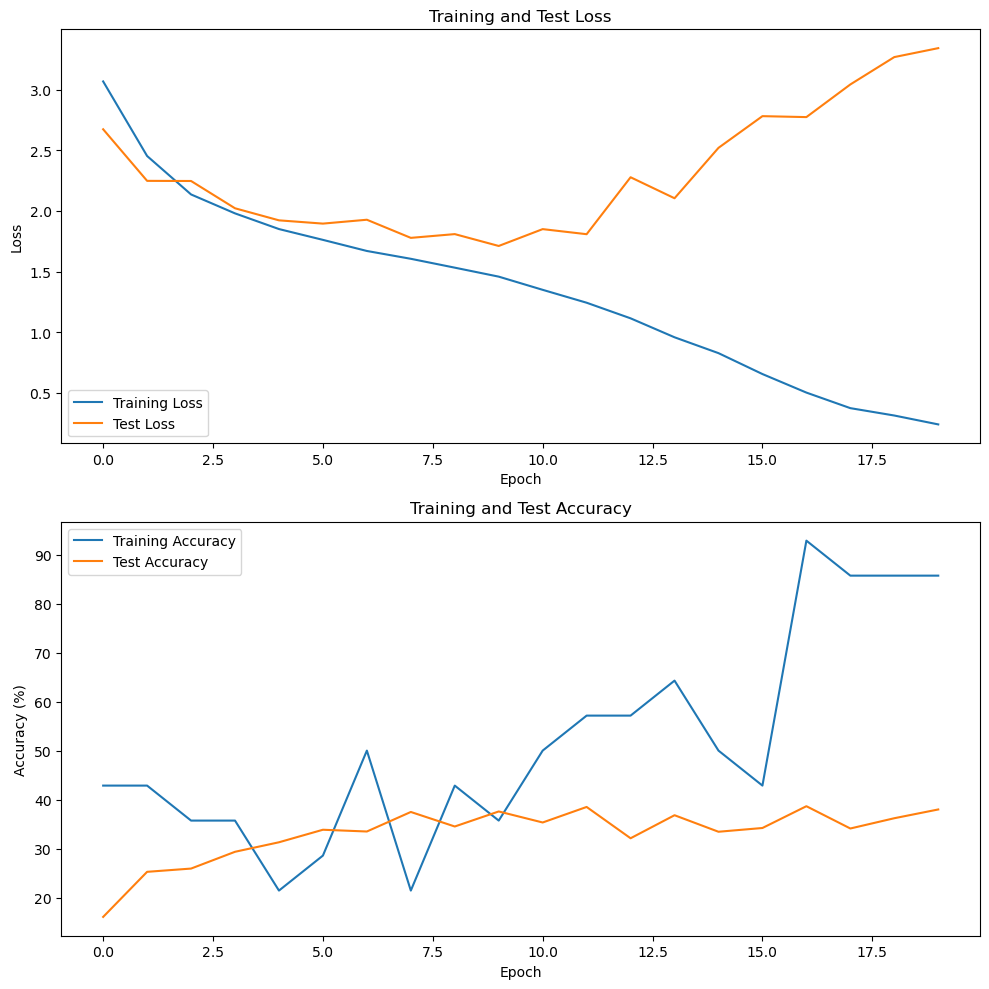

In [44]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-8. resnet18 / RMSprop(lr=0.001, mo=0.5)

In [45]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)

In [46]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [47]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6040, Accuracy: 14.29%
Test loss: 2.3157, Accuracy: 22.29%
Epoch 2, Training loss: 2.1000, Accuracy: 14.29%
Test loss: 2.1100, Accuracy: 25.72%
Epoch 3, Training loss: 1.9197, Accuracy: 21.43%
Test loss: 2.3111, Accuracy: 25.56%
Epoch 4, Training loss: 1.7919, Accuracy: 21.43%
Test loss: 2.4651, Accuracy: 25.77%
Epoch 5, Training loss: 1.6726, Accuracy: 14.29%
Test loss: 2.3539, Accuracy: 24.95%
Epoch 6, Training loss: 1.5918, Accuracy: 28.57%
Test loss: 2.0164, Accuracy: 27.35%
Epoch 7, Training loss: 1.5121, Accuracy: 42.86%
Test loss: 5.0797, Accuracy: 26.02%
Epoch 8, Training loss: 1.4186, Accuracy: 35.71%
Test loss: 2.1081, Accuracy: 33.44%
Epoch 9, Training loss: 1.3298, Accuracy: 42.86%
Test loss: 2.0265, Accuracy: 31.65%
Epoch 10, Training loss: 1.2379, Accuracy: 42.86%
Test loss: 1.9504, Accuracy: 35.94%
Epoch 11, Training loss: 1.1603, Accuracy: 35.71%
Test loss: 2.8442, Accuracy: 31.95%
Epoch 12, Training loss: 1.0652, Accuracy: 35.71%
Test loss: 2.

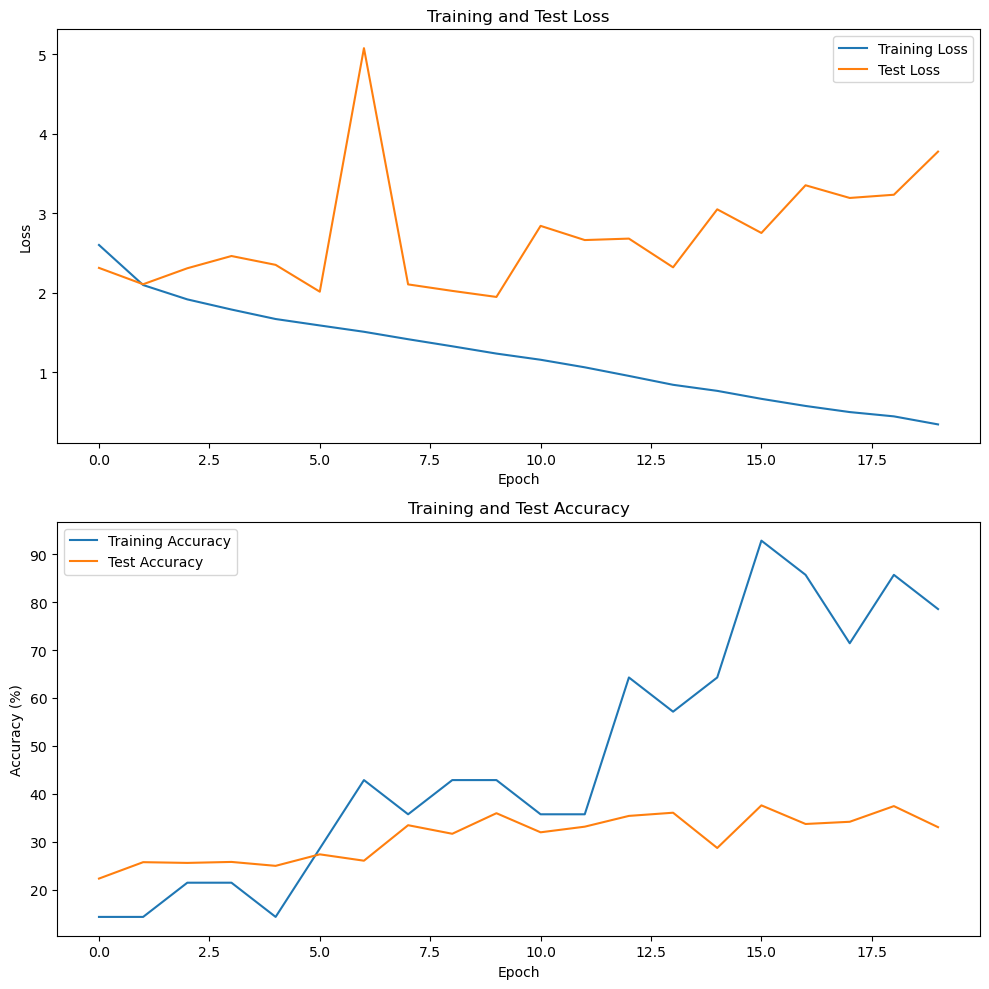

In [48]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-9. resnet18 / RMSprop(lr=0.001, mo=0.25)

In [49]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.25)

In [50]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [51]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6091, Accuracy: 14.29%
Test loss: 2.3860, Accuracy: 20.14%
Epoch 2, Training loss: 2.1349, Accuracy: 14.29%
Test loss: 2.0695, Accuracy: 27.30%
Epoch 3, Training loss: 1.9379, Accuracy: 28.57%
Test loss: 2.3305, Accuracy: 26.43%
Epoch 4, Training loss: 1.8138, Accuracy: 21.43%
Test loss: 2.4646, Accuracy: 21.42%
Epoch 5, Training loss: 1.6961, Accuracy: 35.71%
Test loss: 1.9696, Accuracy: 32.26%
Epoch 6, Training loss: 1.6033, Accuracy: 21.43%
Test loss: 2.1572, Accuracy: 27.76%
Epoch 7, Training loss: 1.5053, Accuracy: 42.86%
Test loss: 2.1462, Accuracy: 29.35%
Epoch 8, Training loss: 1.4151, Accuracy: 28.57%
Test loss: 2.4572, Accuracy: 28.63%
Epoch 9, Training loss: 1.3262, Accuracy: 35.71%
Test loss: 1.8204, Accuracy: 37.99%
Epoch 10, Training loss: 1.2323, Accuracy: 50.00%
Test loss: 2.0492, Accuracy: 35.74%
Epoch 11, Training loss: 1.1200, Accuracy: 57.14%
Test loss: 2.2058, Accuracy: 34.71%
Epoch 12, Training loss: 1.0203, Accuracy: 50.00%
Test loss: 2.

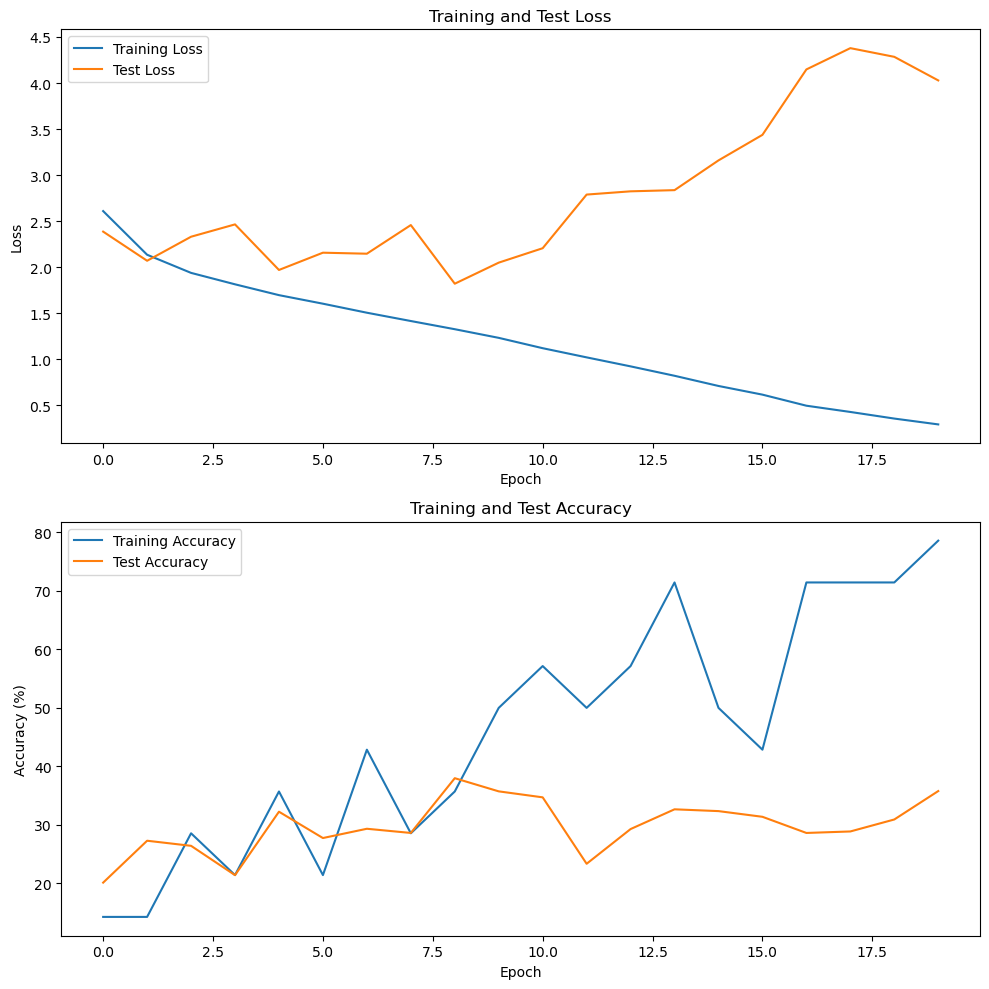

In [52]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)